In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt


In [2]:
data_dir = "./train_samples" 

for root, dirs, files in os.walk(data_dir):
    # ルートディレクトリ名をインデント付きで表示
    depth = root.replace(data_dir, "").count(os.sep)
    indent = "  " * depth
    print(f"{indent}{os.path.basename(root) or data_dir}:")
    # すべての .npy ファイルを表示
    for f in files:
        if f.endswith(".npy"):
            print(f"{indent}  └ {f}")

train_samples:
  CurveFault_A:
    └ seis2_1_0.npy
    └ seis4_1_0.npy
    └ vel2_1_0.npy
    └ vel4_1_0.npy
  CurveFault_B:
    └ seis6_1_0.npy
    └ seis8_1_0.npy
    └ vel6_1_0.npy
    └ vel8_1_0.npy
  CurveVel_A:
    data:
      └ data1.npy
      └ data2.npy
    model:
      └ model1.npy
      └ model2.npy
  CurveVel_B:
    data:
      └ data1.npy
      └ data2.npy
    model:
      └ model1.npy
      └ model2.npy
  FlatFault_A:
    └ seis2_1_0.npy
    └ seis4_1_0.npy
    └ vel2_1_0.npy
    └ vel4_1_0.npy
  FlatFault_B:
    └ seis6_1_0.npy
    └ seis8_1_0.npy
    └ vel6_1_0.npy
    └ vel8_1_0.npy
  FlatVel_A:
    data:
      └ data1.npy
      └ data2.npy
    model:
      └ model1.npy
      └ model2.npy
  FlatVel_B:
    data:
      └ data1.npy
      └ data2.npy
    model:
      └ model1.npy
      └ model2.npy
  Style_A:
    data:
      └ data1.npy
      └ data2.npy
    model:
      └ model1.npy
      └ model2.npy
  Style_B:
    data:
      └ data1.npy
      └ data2.npy
    model:
   

In [3]:
# ① ファイル一覧を集める
data_dir = "./train_samples" 

wave_files = []
vel_files  = []

for family in os.listdir(data_dir):
    fam_path = os.path.join(data_dir, family)
    if not os.path.isdir(fam_path): continue

    # Fault 系：直下に seis*.npy / vel*.npy
    for fname in os.listdir(fam_path):
        if fname.startswith("seis") and fname.endswith(".npy"):
            wave_files.append(os.path.join(fam_path, fname))
        if fname.startswith("vel")  and fname.endswith(".npy"):
            vel_files.append(os.path.join(fam_path, fname))

    # Vel/Style 系：data/*.npy と model/*.npy
    for sub, lst in [("data", wave_files), ("model", vel_files)]:
        subp = os.path.join(fam_path, sub)
        if os.path.isdir(subp):
            for fname in os.listdir(subp):
                if fname.endswith(".npy"):
                    lst.append(os.path.join(subp, fname))

# ソートして対応順を揃える
wave_files.sort()
vel_files.sort()

assert len(wave_files) == len(vel_files), "波形と速度マップの数が合いません"

# ② 全サンプルを一気にロード
all_waves = np.concatenate([np.load(p) for p in wave_files], axis=0)  # shape (10000,5,1000,70)
all_vels  = np.concatenate([np.load(p) for p in vel_files],  axis=0)  # shape (10000,1,70,70)
assert all_waves.shape[0] == all_vels.shape[0]

# ③ インデックスをシャッフル
N = all_waves.shape[0]
idx = np.random.permutation(N)

waves_shuffled = all_waves[idx]
vels_shuffled  = all_vels[idx]

# ④ 1,000サンプルずつ 10個のファイルに分割して保存
out_dir = "./small_batches"
os.makedirs(out_dir, exist_ok=True)

batch_size = 1000
num_batches = N // batch_size  # =10

for i in range(num_batches):
    start = i * batch_size
    end   = (i+1) * batch_size
    w_batch = waves_shuffled[start:end]
    v_batch = vels_shuffled[start:end]
    np.save(os.path.join(out_dir, f"waves_batch_{i+1:02d}.npy"), w_batch)
    np.save(os.path.join(out_dir, f"vels_batch_{i+1:02d}.npy"),  v_batch)
    print(f"Saved batch {i+1}: waves_batch_{i+1:02d}.npy, vels_batch_{i+1:02d}.npy")


Saved batch 1: waves_batch_01.npy, vels_batch_01.npy
Saved batch 2: waves_batch_02.npy, vels_batch_02.npy
Saved batch 3: waves_batch_03.npy, vels_batch_03.npy
Saved batch 4: waves_batch_04.npy, vels_batch_04.npy
Saved batch 5: waves_batch_05.npy, vels_batch_05.npy
Saved batch 6: waves_batch_06.npy, vels_batch_06.npy
Saved batch 7: waves_batch_07.npy, vels_batch_07.npy
Saved batch 8: waves_batch_08.npy, vels_batch_08.npy
Saved batch 9: waves_batch_09.npy, vels_batch_09.npy
Saved batch 10: waves_batch_10.npy, vels_batch_10.npy


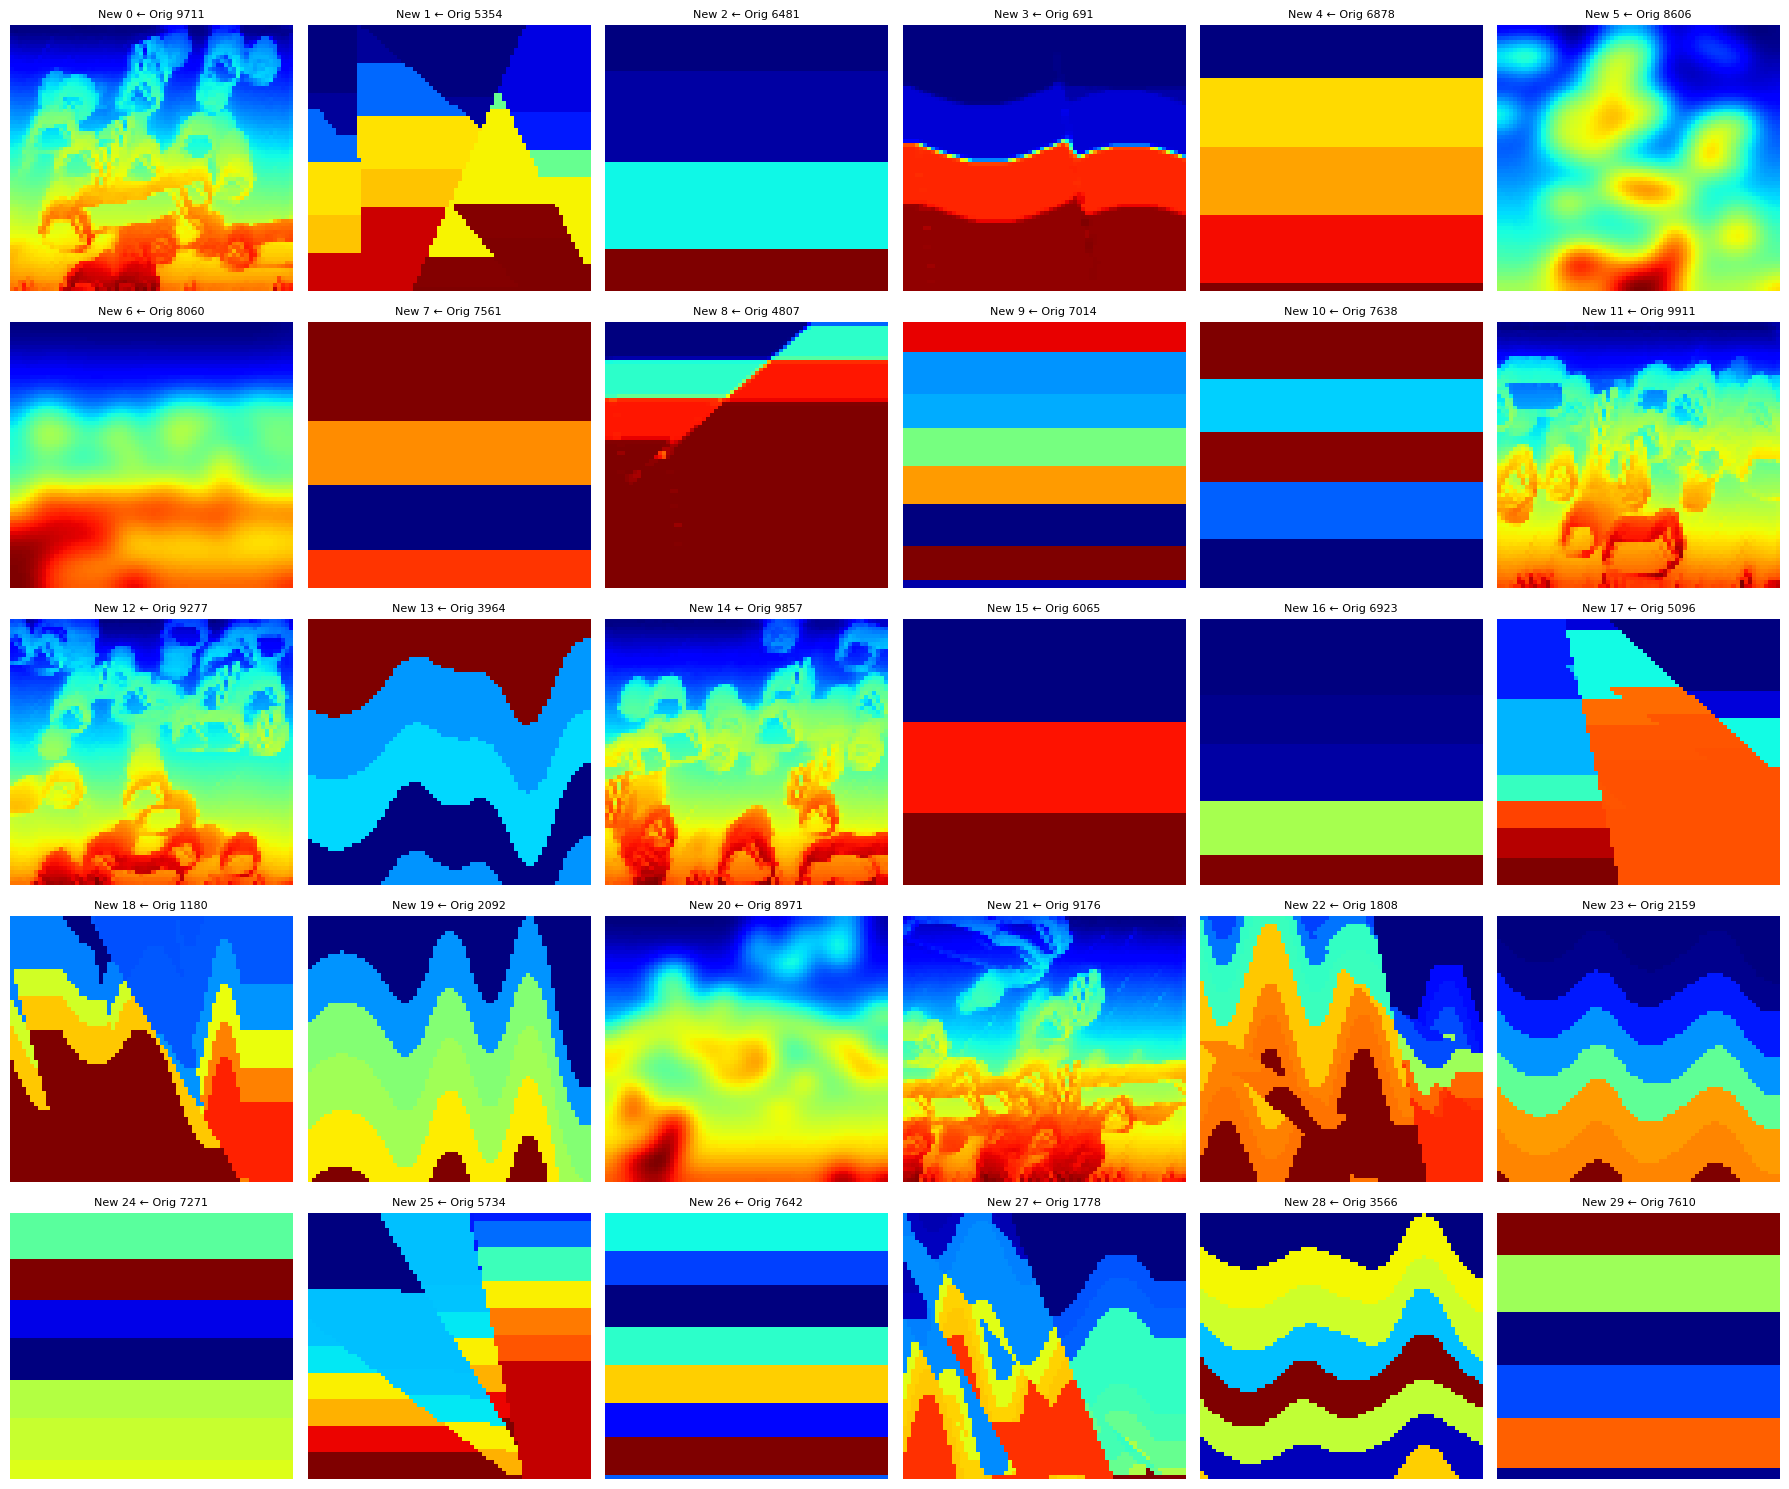

In [4]:

# 表示する枚数
n = 30
cols = 6
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
axes = axes.flatten()

for i in range(n):
    orig_i = idx[i]  # 新しい位置 i に対応する「元のインデックス」
    ax = axes[i]
    ax.imshow(vels_shuffled[i, 0], cmap='jet', aspect='auto')
    ax.set_title(f"New {i} ← Orig {orig_i}", fontsize=8)
    ax.axis('off')

# 余ったサブプロットは消しておく
for j in range(n, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class WaveformDataset(Dataset):
    def __init__(self, waves_path, vels_path):
        self.waves = np.load(waves_path)  # shape (N, 5,1000,70)
        self.vels  = np.load(vels_path)   # shape (N, 1,70,70)
    def __len__(self):
        return len(self.waves)
    def __getitem__(self, idx):
        x = torch.from_numpy(self.waves[idx]).float()
        y = torch.from_numpy(self.vels[idx]).float()
        return x, y

# 例: 1つ目のバッチを読み込む
ds = WaveformDataset("small_batches/waves_batch_01.npy",
                     "small_batches/vels_batch_01.npy")
loader = DataLoader(ds, batch_size=32, shuffle=True)

for xb, yb in loader:
    print(xb.shape, yb.shape)  # torch.Size([32,5,1000,70]), torch.Size([32,1,70,70])
    break


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([32, 5, 1000, 70]) torch.Size([32, 1, 70, 70])
